# **CAS M6 - Part I**

Filipe Maximiano Sousa & Laura Cunha Silva 



*   Convolutional Neural Networks application to Image classification dataset 


Import Images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Mount drive 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Set data paths 

In [ ]:
train_path="/content/drive/MyDrive/CAS_M3/Train"
test_path="/content/drive/MyDrive/CAS_M3/Test"
val_path="/content/drive/MyDrive/CAS_M3/Validation"


Upload training set 

In [ ]:
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr= cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

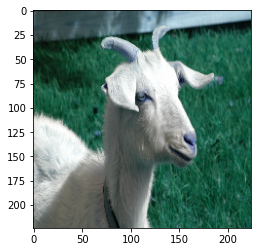

In [ ]:
plt.imshow(x_train[7])
     

Upload validation test 

In [ ]:
x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)
     


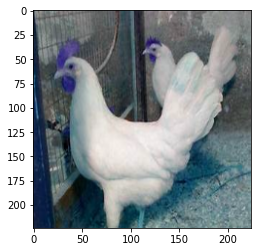

In [ ]:
plt.imshow(x_val[3])

Upload test set 

In [ ]:
x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))
        
        x_test.append(img_arr)

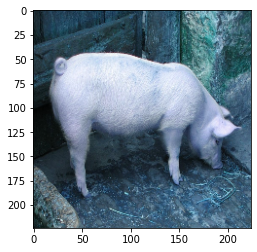

In [ ]:
plt.imshow(x_test[3])

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
     

**Data Preparation**

So we are not aware of the Data/Class Distribution, it's time to load the data and apply some **preprocessing**.

All classes are not equally distributed but on an average the class distribution is the same. 
The number of images assigned to each class is very low  due to which it can be tough for the model to learn the data effectively.

> We will therefore apply deep learning techniques to increase our dataset and to tr to achieve a higher model accuracy. We will start by applying data augmentation.

 **When Should You Use Data Augmentation?** 

*   To prevent models from overfitting.
*   The initial training set is too small.m
*   To improve the model accuracy.
*   To Reduce the operational cost of labeling and cleaning the raw dataset.

Reference:

https://www.datacamp.com/tutorial/complete-guide-data-augmentation

https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf

1.   train = 923 images
2.   test = 282 images
3.   validation = 230 images


## **Data Augmentation with Keras Sequential** 

We usually use keras.Sequential() to build the model, but we can also use it to add augmentation layers.  

> *Resize and rescale* 

> In the example, we are resizing and rescaling the image. We will first resize the image to 224X224 and then rescale it by 1/255. The small image size will help us save time, memory, and computing.



In [ ]:
train_path="/content/drive/MyDrive/CAS_M3/Train"
test_path="/content/drive/MyDrive/CAS_M3/Test"
val_path="/content/drive/MyDrive/CAS_M3/Validation"

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 923 images belonging to 11 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(val_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 230 images belonging to 11 classes.


In [ ]:
class_dictionary = train_generator.class_indices
#---create a dictionary of labels---
class_dictionary = { value:key for key,value in
    class_dictionary.items()}
#---convert the dictionary to a list---
class_list = [value for _,value in class_dictionary.items()]
print(class_list)

['camel', 'cat', 'chicken', 'cow', 'dog', 'donkey', 'goat', 'horse', 'pig', 'sheep', 'turkey']


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : camel
1 : cat
2 : chicken
3 : cow
4 : dog
5 : donkey
6 : goat
7 : horse
8 : pig
9 : sheep
10 : turkey


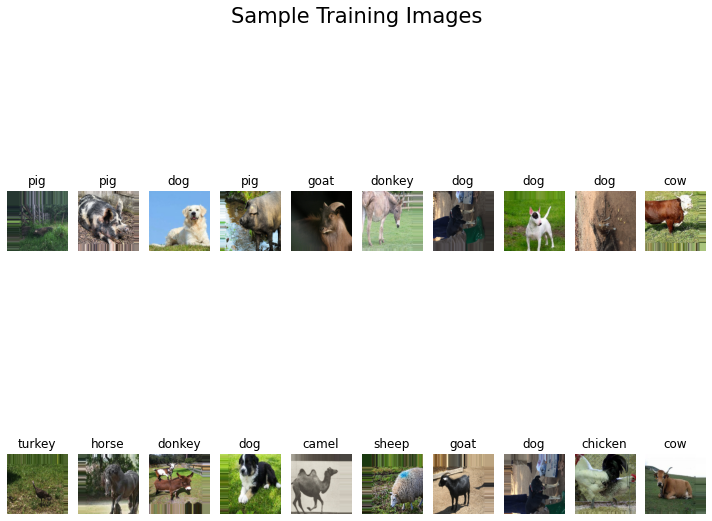

In [ ]:
#Plot
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(10, 10))
idx = 0

for i in range(2):
    for j in range(10):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

## **Building a model using transfer learning**


**Define A Model**

We are going to define a series of Convolution Layers, and each convolution layer consists of a convolution operation followed by a max pool layer.

This order is not mandatory- you can have two Convolution operations followed by one max pool, or three, or an average pool- that's the neat part of neural networks, they're so adaptable and malleable, and the best configurations are often found out by trial and error.

In this case, we are going with the wisdom of our elders, and go by this order.

**Head of A CNN**

> As we apply more Conv Layers, you will get a transformed matrix of somesize x somesize. 

> But what good is a matrix to us? We need a simple answer- 0 or 1! In order to get this answer, we "flatten" the final matrix to a single vector of size somesize-times-2 x 1. Then we pass it through more neural network neurons to get a single neuron at the end. This neuron's output is constrained between 0 and 1. This is our final probability! If it's greater than 0.5, the prediction is 1, if not, it's 0.

> If you have more than 2 classes, like predicting a digit. In this case, there would be ten neurons at the end. Each of their output would be the probability of that class.

**Model Hyperparameters**

> Apart from number of Conv layers, there are other design choices while designing a CNN. They include: 
-  selecting the optimizer, the learning rate, the loss function, the number of filters.
> What's important to note: 
-Passing the input shape to the first layer. 
-*Ensuring that the last layer corresponds to the number of classes.*

Reference:https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn 


**Build a simple CNN**

CNN (Convolutional neural network or ConvNet) is a class of deep neural networks, commonly applied to analyzing visual imagery. Here is the simpliest example of CNN with few layers using Conv2D - 2D convolution layer (spatial convolution over images) and MaxPooling2D - application of a moving window across a 2D input space.

*I. Provide Hyperparameters*

> Hyperparameters are set before training; they represent the variables which determines the neural network structure and how the it is trained.

**Parameters for layers**

- *Convolutional layer filter size (filters)*. 
> The number of filters should depend on the complexity of dataset and the depth of neural network. A common setting to start with is [32, 64, 128] for three layers.

- *kernel_size* = number of filters = a small window of pixels at a time (3×3) which will be moved until the entire image is scanned. If images are smaller than 128×128, work with smaller filters of 1×1;

- Width and Height of images were already provided. 2D convolutional layers take a three-dimensional input, typically an image with three color channels;

- *max_pool* = max pooling is the application of a moving window across a 2D input space, where the maximum value within that window is the output: 2x2.

# **Model's architecture**

The Sequential model is a linear stack of layers.

Conv2D with hypermarameters mantioned above: 
- Conv2D(kernel_size, (filters, filters), input_shape=(img_w, img_h, 3)) with activation function for each layer as a Rectified Linear Unit (ReLU): Activation('relu')

- MaxPooling2D layer to reduce the spatial size of the incoming features; 2D input space: MaxPooling2D(pool_size=(max_pool, max_pool))
Do the same increading the kernel size: 32 -> 64 -> 128 -> 128 -> 128

- Flatten the input: transform the multidimensional vector into a single dimensional vector: Flatten()

- Add dropout layer which randomly sets a certain fraction of its input to 0 and helps to reduce overfitting: Dropout(0.5)

- Add fully connected layer with 512 nodes and activation function relu: Dense(512), Activation('relu')

- Provide last fully connected layer which specifies the number of classes of gemstones: 87. 

- Softmax activation function outputs a vector that represents the probability distributions of a list of potential outcomes: Dense(87, activation='softmax')

- Print the summary of the model.

In [ ]:
#Train CNN model
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=11, activation='softmax')
    ])
    
    return model

In [ ]:
cnn_model = create_model()

In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     9728      
                                                                 
 activation (Activation)     (None, 220, 220, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 108, 108, 64)      0

### Let's visualize how our network looks like, and what the shapes of input and output at each layer.





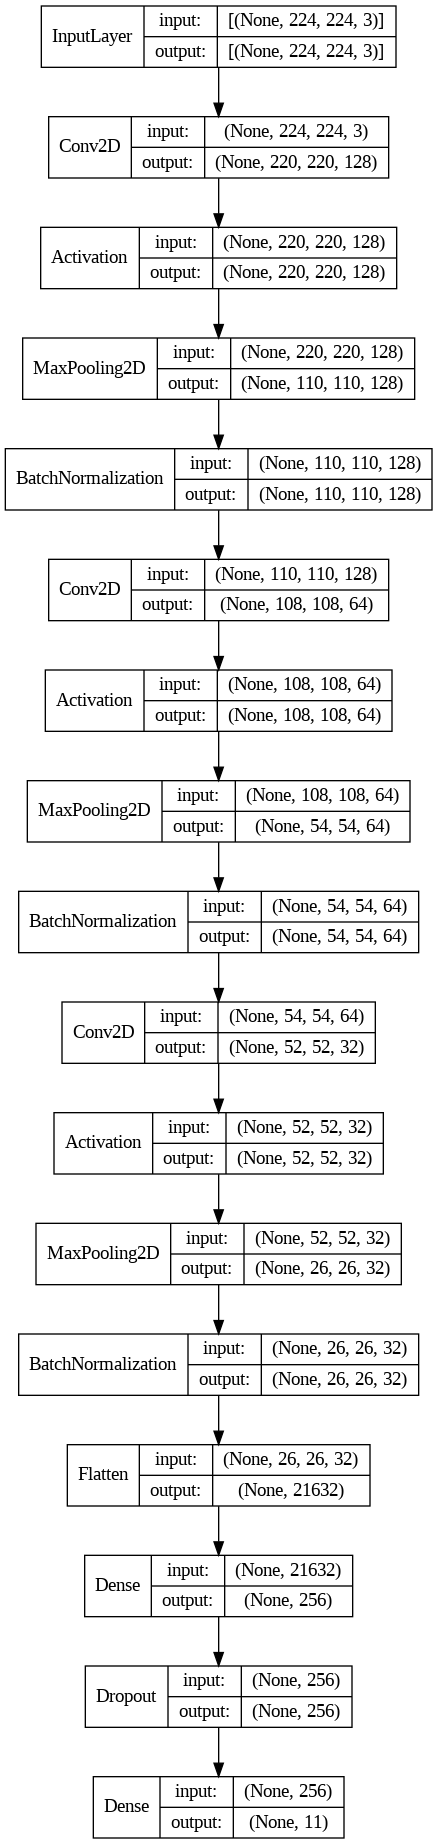

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(cnn_model, show_shapes=True, show_layer_names=False)

**2. Parameters to fit the model**

- **Epoch**

> Describes the number of times the algorithm sees the ENTIRE dataset. Each time the algo has seen all samples in the dataset, an epoch has completed.
Since one epoch is too big to feed to the memory at once divide it in several smaller batches. Batch size is always factor of 2.

- **Iterations per epoch** = number of passes, each pass using batch size number of examples.

> Example, if we have ~2200 (80%) training samples, and batch size is 32, then it will take ~70 iterations to complete 1 epoch.



**Defining Callbacks**
> A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

**Reduce Learning Rate on Plateau**
> Is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [ ]:
optimizer = Adam(learning_rate=0.001)

**Compile the model**

> Compile the model using adam optimizer which is a generalization of stochastic gradient descent (SGD) algo. Provided loss function is sparse_categorical_crossentropy as we are doing multiclass classification.

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(train_generator, epochs=83, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr]) #83 epochs = number of images/number of classes =  923 / 11 = 83

Epoch 1/83
29/29 - 64s - loss: 8.2743 - accuracy: 0.1452 - val_loss: 4.7765 - val_accuracy: 0.1217 - lr: 0.0010 - 64s/epoch - 2s/step
Epoch 2/83
29/29 - 59s - loss: 8.6274 - accuracy: 0.1961 - val_loss: 5.5274 - val_accuracy: 0.1000 - lr: 0.0010 - 59s/epoch - 2s/step
Epoch 3/83
29/29 - 59s - loss: 7.5454 - accuracy: 0.1798 - val_loss: 5.6557 - val_accuracy: 0.1783 - lr: 0.0010 - 59s/epoch - 2s/step
Epoch 4/83
29/29 - 60s - loss: 5.5987 - accuracy: 0.2134 - val_loss: 4.0363 - val_accuracy: 0.1304 - lr: 0.0010 - 60s/epoch - 2s/step
Epoch 5/83
29/29 - 59s - loss: 4.5727 - accuracy: 0.1885 - val_loss: 3.1619 - val_accuracy: 0.2130 - lr: 0.0010 - 59s/epoch - 2s/step
Epoch 6/83
29/29 - 58s - loss: 3.7078 - accuracy: 0.2189 - val_loss: 6.4493 - val_accuracy: 0.0826 - lr: 0.0010 - 58s/epoch - 2s/step
Epoch 7/83
29/29 - 59s - loss: 3.2624 - accuracy: 0.2427 - val_loss: 3.3498 - val_accuracy: 0.2174 - lr: 0.0010 - 59s/epoch - 2s/step
Epoch 8/83
29/29 - 69s - loss: 2.8478 - accuracy: 0.2199 - val

# **Plotting the Model Metrics**

> Plotting training and validation accuracy, loss and learning rate


In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

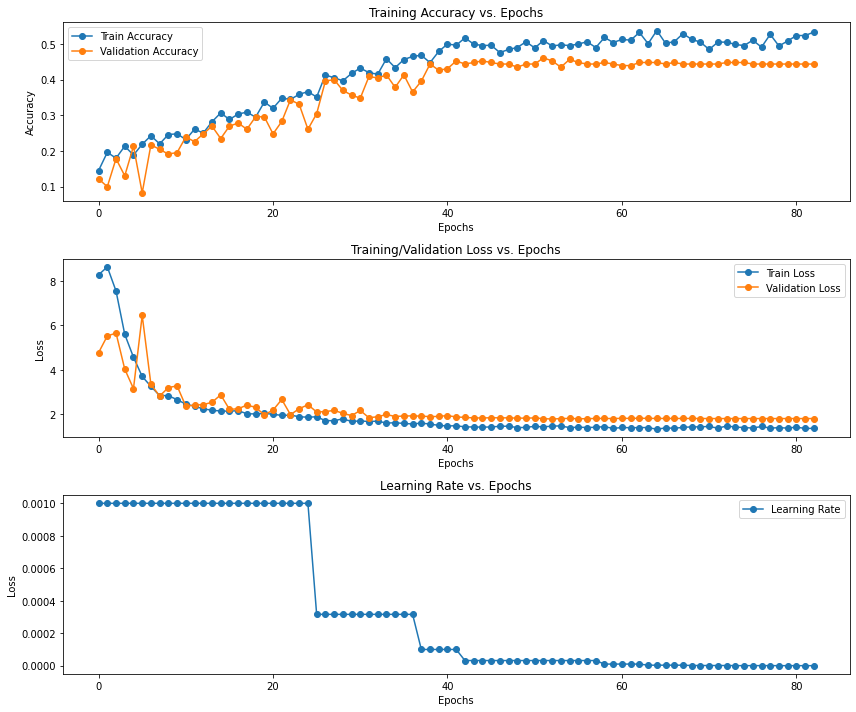

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

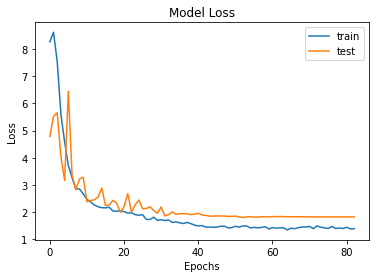

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

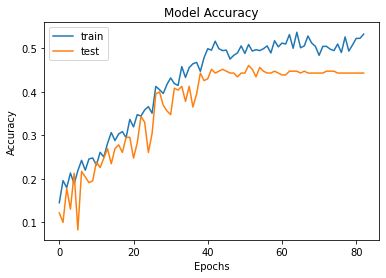

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# **Interpretation of the produced graphs**

**Training/Validation Loss vs. Epochs**

These loss curves give us a better insight into how the learning performance changes over the number of epochs and help us diagnose any problems with learning that can lead to an underfit or an overfit model. 

References: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/


**6. Testing the Model on Test Set**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 282 images belonging to 11 classes.


**7. Model Prediction on the Test Dataset**

In [ ]:
predictions = cnn_model.predict(test_generator)

9/9 [==============================] - 14s 2s/step


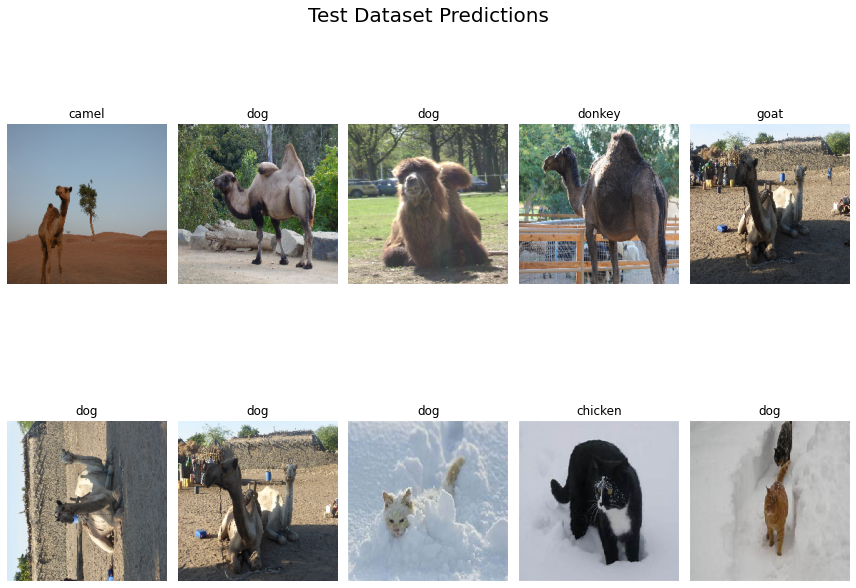

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

9/9 [==============================] - 15s 2s/step - loss: 1.7055 - accuracy: 0.4574


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1.7054532766342163
Test Accuracy: 0.457446813583374


**Plotting the Classification Metrics**

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

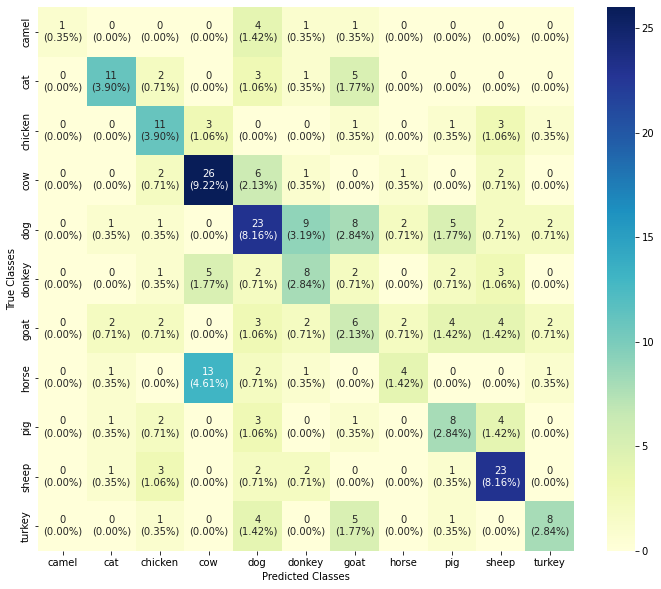

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(11, 11)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

**Wrong Predictions**


> Let's see where the model has given wrong predictions and what were the actual predictions on those images.



In [ ]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

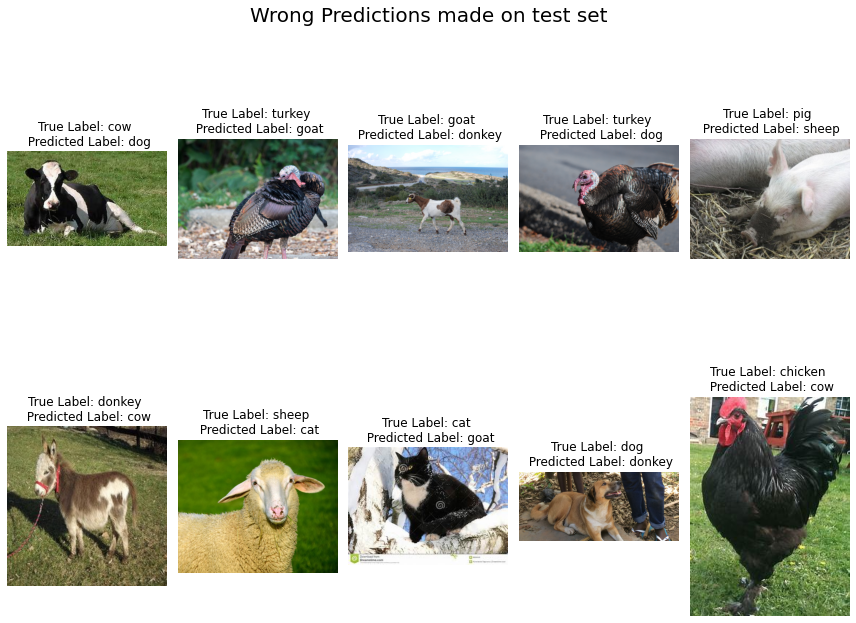

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [ ]:
#END